In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

sys.path.append('..')
from sim_cosmology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_1dfilts, get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# load results

In [2]:
dirs = ["db5_saliency_warmstart_lamL1wave=0.01_seed=100"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/ex_cosmology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## load data and model

In [3]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)
torch.manual_seed(p.seed)
data = iter(test_loader).next()[0].to(device)

# Plotting

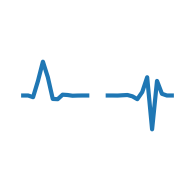

Hyperparameter: lamL1wave=0.010000 lamL1attr=0.021210


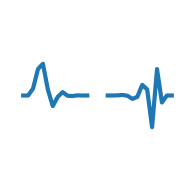

In [4]:
res = results[0]
mos = models[0]
lamL1attr = np.array(res['lamL1attr'])
index = {}
for i in range(len(lamL1attr)):
    index[i] = np.argsort(lamL1attr)[i]
rec_loss = np.array(res['rec_loss'])[np.argsort(lamL1attr)]
L1saliency_loss = np.array(res['L1saliency_loss'])[np.argsort(lamL1attr)]
L1inputxgrad_loss = np.array(res['L1inputxgrad_loss'])[np.argsort(lamL1attr)]  

ix = 4
wt = mos[index[ix]]
filt = get_2dfilts(wt)
plot_1dfilts(filt[0], figsize=(1,1))

print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[ix]], res['lamL1attr'][index[ix]]))

# original wavelet
wt_o = DWT2d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt_o = get_2dfilts(wt_o)
plot_1dfilts(filt_o[0], figsize=(1,1))

Reconstruction error=0.02174


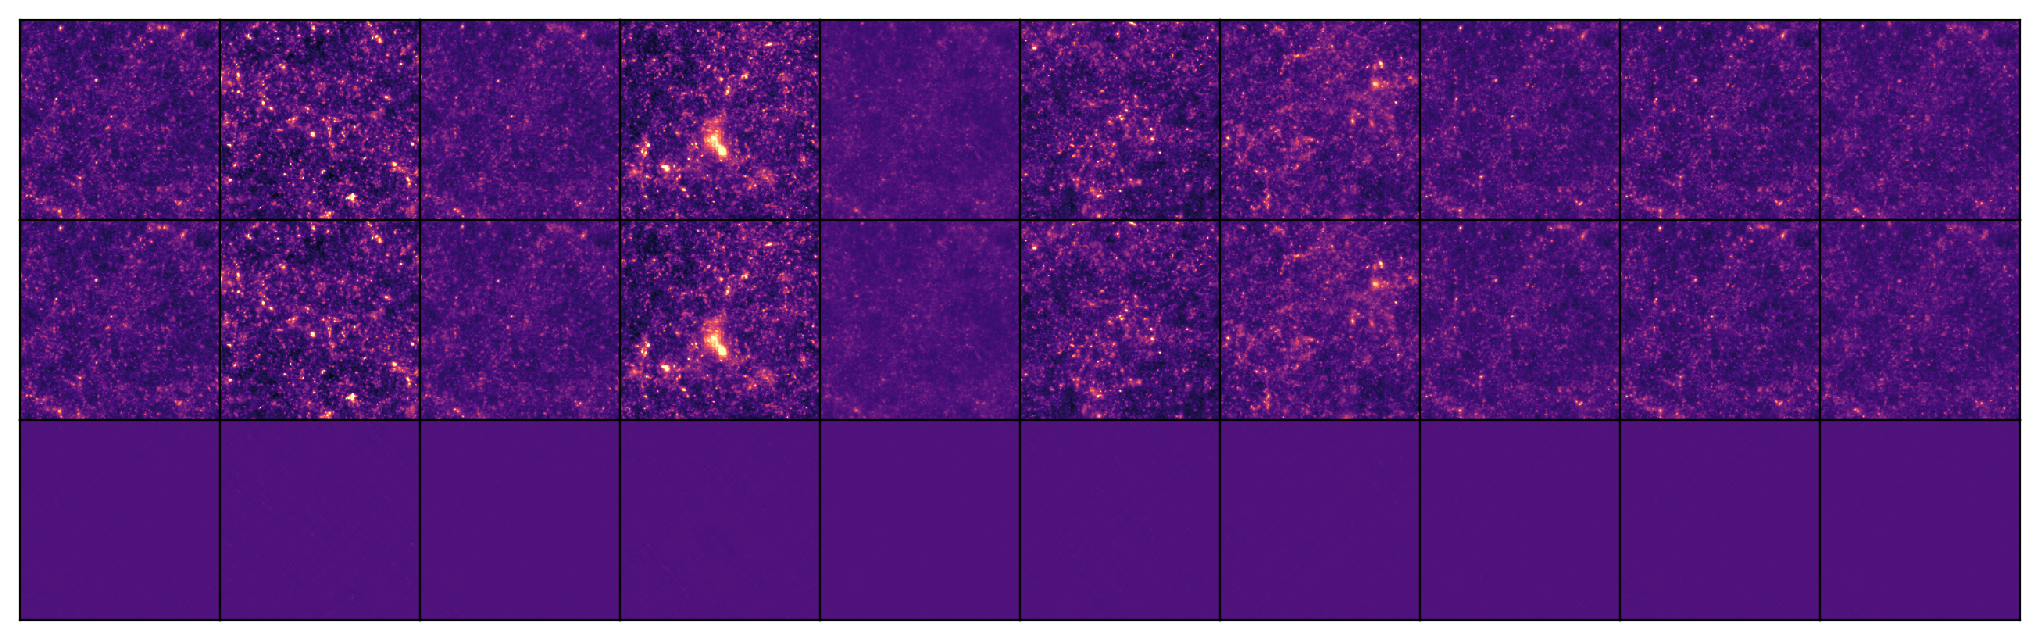

In [5]:
#### plot original and reconstruction images
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))
plot_2dreconstruct(data, recon)

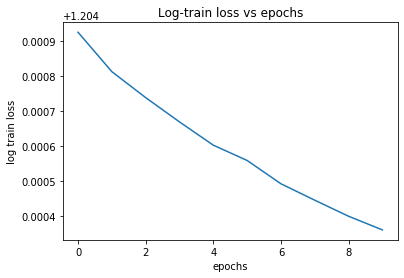

In [6]:
plt.plot(np.log(res['train_losses'][index[ix]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [7]:
# validator 
validator = Validator(model, test_loader)

# original wavelet transform
rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=0)
rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=0)

print("\n\n \t Original filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
        Adaptive filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))



 	 Original filter:Reconstruction Error=0.00000 sum loss=0.00000 L2norm loss=0.00000 CMF loss=0.00000 L1wave loss=99.52343 L1saliency loss=77.34519 L1inputxgrad loss=0.55857 
         Adaptive filter:Reconstruction Error=0.02221 sum loss=0.00000 L2norm loss=0.00005 CMF loss=0.00098 L1wave loss=96.24394 L1saliency loss=76.03246 L1inputxgrad loss=0.53486


In [8]:
phi, psi, x = get_wavefun(wt)

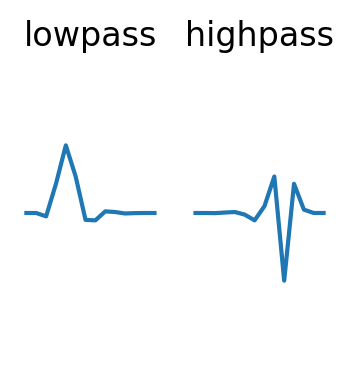

In [9]:
plot_1dfilts(filt[0], is_title=True, figsize=(2,2))

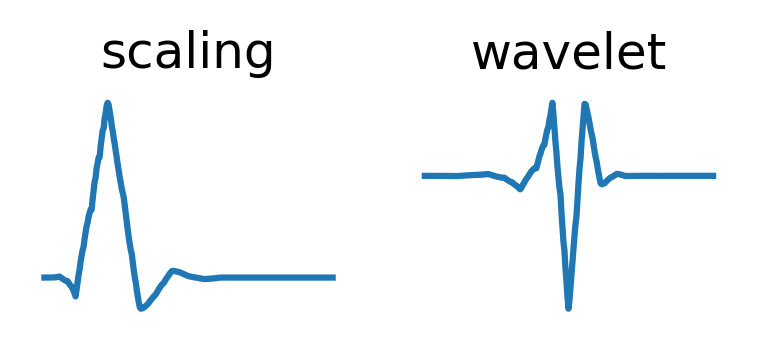

In [10]:
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))